Turning the raw image into monochrome black & white image:

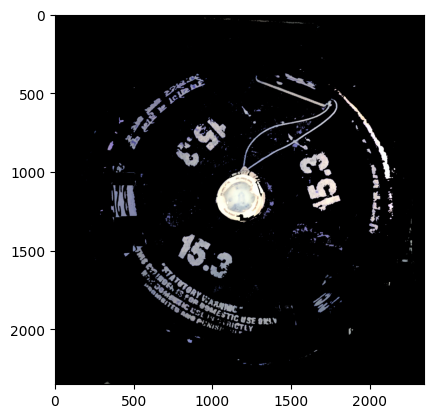

In [259]:
import sys

import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract

sys.path.append('..')
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

from shared import getMonochromeImage

loadedImage = cv2.imread('../images/Cylinder_image.jpg')
image = getMonochromeImage(loadedImage)
plt.imshow(image)

Cropping the image to the closest  region where the number is:

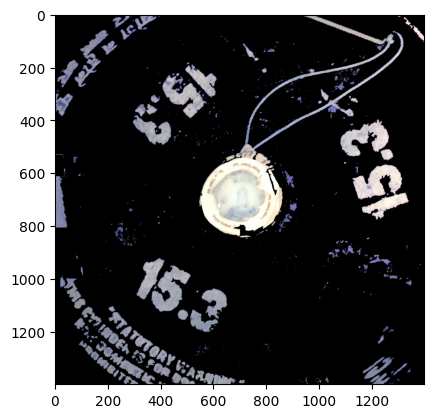

In [260]:
def getCroppedImage(image):
    image_height, image_width, _ = image.shape

    # Define the desired width and height of the crop
    crop_width = 1400
    crop_height = 1400

    # Calculate the coordinates for cropping the center region
    x1 = int(image_width/2 - crop_width/2)
    y1 = int(image_height/2 - crop_height/2)
    x2 = int(image_width/2 + crop_width/2)
    y2 = int(image_height/2 + crop_height/2)

    cropped_image = image[y1:y2, x1:x2]
    return cropped_image

cropped_image = getCroppedImage(image)
plt.imshow(cropped_image)

Box the region where the numbers are located. Get the contour of these boxes in a list.

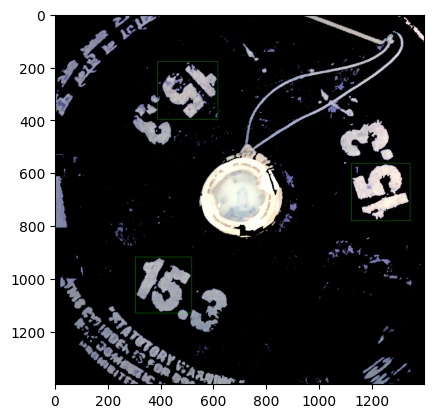

In [261]:
def getContours(image):
    thresh = cv2.adaptiveThreshold(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 7)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def getNumberPos(image):
    contours=getContours(image)
    number_positions=[]

    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)

        if (
            area > 1000
            and 1 < w / h < 1.2
            and h > 200 and h <= 300
        ):
            number_positions.append({'pos':(x,y),'cnt': contour})
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
    return number_positions

number_positions=getNumberPos(cropped_image)
plt.imshow(cropped_image)


Track the contours near these positions.

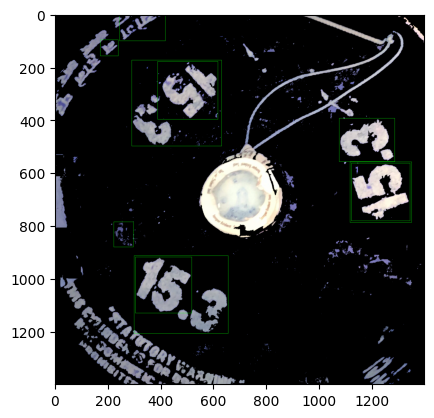

In [262]:
def getNearbyContours(image, posList, contours):
    # Set the maximum distance threshold to filter contours
    max_distance = 200

    # Filter contours near the point of interest
    filtered_contours = []

    for cntData in posList:
        point_of_interest=cntData['pos']
        for cnt in contours:
             # Calculate the contour area
            area = cv2.contourArea(cnt)
            x, y, w, h = cv2.boundingRect(cnt)

            if area > 1000:
                # Calculate the distance between the contour centroid and the point of interest
                M = cv2.moments(cnt)
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                distance = np.sqrt((cx - point_of_interest[0])**2 + (cy - point_of_interest[1])**2)

                # Retain the contour if it falls within the distance threshold
                if distance <= max_distance:
                    filtered_contours.append({'pos':(x,y),'cnt': cnt})
                    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)

    return filtered_contours


nearby_contours = getNearbyContours(cropped_image, number_positions, getContours(cropped_image))
plt.imshow(cropped_image)

Filter out the overlapping contours.

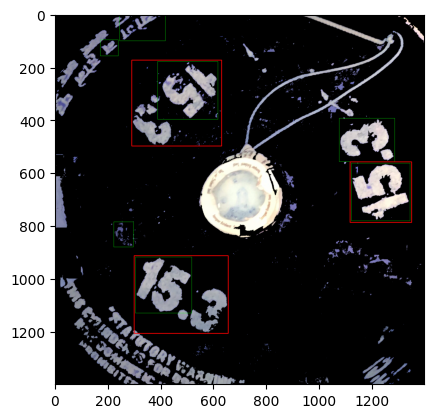

In [263]:
def check_contour_overlap(contour1, contour2):
    # Get the bounding rectangles of the contours
    x1, y1, w1, h1 = cv2.boundingRect(contour1)
    x2, y2, w2, h2 = cv2.boundingRect(contour2)

    # Calculate the coordinates of the top-left and bottom-right corners of the rectangles
    rect1_tl = (x1, y1)
    rect1_br = (x1 + w1, y1 + h1)
    rect2_tl = (x2, y2)
    rect2_br = (x2 + w2, y2 + h2)

    # Check if the rectangles intersect
    if rect1_tl[0] < rect2_br[0] and rect1_br[0] > rect2_tl[0] and rect1_tl[1] < rect2_br[1] and rect1_br[1] > rect2_tl[1]:
        return True  # Contours overlap
    else:
        return False  # Contours do not overlap
    
def filterNumberImages(image, number_positions, nearby_contours):
    for parentCntData in nearby_contours:
        for childCntData in number_positions:
            if(check_contour_overlap(parentCntData['cnt'],childCntData['cnt'])):
                x, y, w, h = cv2.boundingRect(parentCntData['cnt'])
                cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)


filterNumberImages(cropped_image, number_positions, nearby_contours)
plt.imshow(cropped_image)